# Wine Varietal Predictor: Sentiment Analysis of Tasting Notes (AI Sommelier)

![](https://i0.wp.com/www.agoda.com/wp-content/uploads/2019/09/Napa-Valley-wine-region-wine-tasting-tours.jpg)

# Motivation 

🍷 The goal of this project is to create a model which is able to take in an input in the way of a sommeliers description of a wine and output which ratings category that wine would fall into. 

🍷 Further investigation will be undertaken to see if my model could look at wine descriptions and output wine varietals and country of origin.



# Import Libraries

In [1]:
import gzip

# data manipulation
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

# models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import log_loss

# plotting
from matplotlib import pyplot as plt
import seaborn as sns

# Wine descriptions
import nltk
import seaborn as sns 
import matplotlib.pyplot as plt
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('punkt')
import nltk.sentiment
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# Importing CSV

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
main_df_1 = pd.read_csv("/content/drive/MyDrive/Kaggle Data/winemag-data-130k-v2.csv")

In [4]:
main_df_1

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.0,Mosel,NaN,NaN,Anna Lee C. Iijima,NaN,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef)
129967,129967,US,Citation is given as much as a decade of bottl...,NaN,90,75.0,Oregon,Oregon,Oregon Other,Paul Gregutt,@paulgwine,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation
129968,129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser
129969,129969,France,"A dry style of Pinot Gris, this is crisp with ...",NaN,90,32.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss


# Data Preprocessing

**Preprocessing steps:**

🍷 Drop nulls in Country column

🍷 Drop nulls in Province column

🍷 Drop nulls in Variety column

🍷 Drop Unnamed: 0 column (redundant)

🍷 Drop Designation column (information repeated in title)

🍷 Change type of points column to float

🍷 Eliminate outliers in Points and Price columns

In [5]:
main_df_1.isnull().sum()

Unnamed: 0                   0
country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

In [6]:
main_df_1.dropna(subset=['variety', 'country', "province"], inplace = True)

In [7]:
main_df_1.drop(columns = ["Unnamed: 0", "designation"], inplace = True)

In [8]:
main_df_1

,country,description,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
...,...,...,...,...,...,...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,90,28.0,Mosel,NaN,NaN,Anna Lee C. Iijima,NaN,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef)
129967,US,Citation is given as much as a decade of bottl...,90,75.0,Oregon,Oregon,Oregon Other,Paul Gregutt,@paulgwine,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation
129968,France,Well-drained gravel soil gives this wine its c...,90,30.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser
129969,France,"A dry style of Pinot Gris, this is crisp with ...",90,32.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss


In [9]:
main_df_1.dtypes

country                   object
description               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
dtype: object

In [10]:
main_df_1.points.astype('float64')

0         87.0
1         87.0
2         87.0
3         87.0
4         87.0
          ... 
129966    90.0
129967    90.0
129968    90.0
129969    90.0
129970    90.0
Name: points, Length: 129907, dtype: float64

## Lets take a look at the outliers

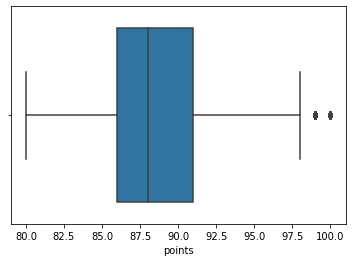

In [11]:
sns.boxplot(x=main_df_1['points'])

🍷 We can see that the minimum and maximum whiskers of the datasets boxplot are at around 80 points and around 98 points respectively

🍷 There seem to be several wines which fall outside of this scope (outliers) and they will be controlled for below.

🍷 Similarly, I used the Inter Quartile Range technique to eliminate the outliers for Price. 

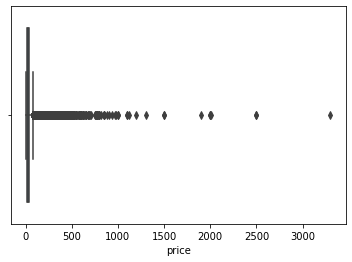

In [12]:
sns.boxplot(x=main_df_1['price'])

In [13]:
Q1 = main_df_1.quantile(0.25)
Q3 = main_df_1.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

points     5.0
price     25.0
dtype: float64


In [14]:
main_df_1 = main_df_1[~((main_df_1 < (Q1 - 1.5 * IQR)) |(main_df_1 > (Q3 + 1.5 * IQR))).any(axis=1)]
main_df_1.shape

(122657, 12)

In [15]:
main_df_1

,country,description,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
...,...,...,...,...,...,...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,90,28.0,Mosel,NaN,NaN,Anna Lee C. Iijima,NaN,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef)
129967,US,Citation is given as much as a decade of bottl...,90,75.0,Oregon,Oregon,Oregon Other,Paul Gregutt,@paulgwine,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation
129968,France,Well-drained gravel soil gives this wine its c...,90,30.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser
129969,France,"A dry style of Pinot Gris, this is crisp with ...",90,32.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss


🍷 Above is the final table after contolling for Outliers. 

🍷 Around 7000 entries were classified as outliers and cleaned 

# EDA 

## Points EDA

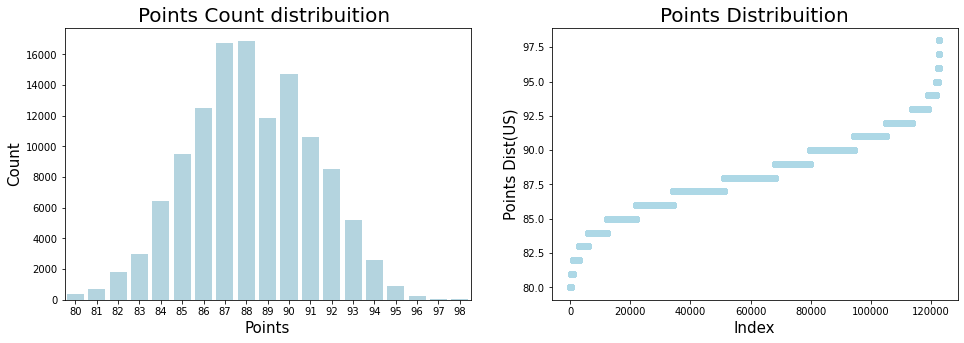

In [16]:
plt.figure(figsize=(16,5))

plt.subplot(1,2,1) 
g = sns.countplot(x='points', data=main_df_1, color='lightblue') 
g.set_title("Points Count distribuition ", fontsize=20) 
g.set_xlabel("Points", fontsize=15) 
g.set_ylabel("Count", fontsize=15) 

plt.subplot(1,2,2)  
plt.scatter(range(main_df_1.shape[0]), np.sort(main_df_1.points.values), color='lightblue') 
plt.xlabel('Index', fontsize=15)  
plt.ylabel('Points Dist(US)', fontsize=15) 
plt.title("Points Distribuition", fontsize=20) 

plt.show() 

🍷 Our wines all fall between a rating of 79 and 98 points out of 100

🍷  Most of the wines seem to be rated between 84 and 93

🍷 Lets try clustering the points into categories

In [17]:
conditions = [
    (main_df_1['points'] >= 93),
    (main_df_1['points'] >= 90) & (main_df_1['points'] < 93),
    (main_df_1['points'] >= 87) & (main_df_1['points'] < 90),
    (main_df_1['points'] >= 84) & (main_df_1['points'] < 87),
    (main_df_1['points'] < 84)]
    
    

# create a list of the values we want to assign for each condition
values = ['1st', '2nd', '3rd', "4th", "5th"]

# create a new column and use np.select to assign values to it using our lists as arguments
main_df_1['Points_Tier'] = np.select(conditions, values)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


🍷 The 5 tiers chosen can be listed as follows:

**Tier 1:** Above 93 points (SPECTACULAR)

**Tier 2:** Between 90 and 93 points (EXCELLENT)

**Tier 3:** Between 87 and 90 points (VERY GOOD)

**Tier 4:** Between 84 and 87 points (GOOD)

**Tier 5:** Below 84 points (AVERAGE)

In [18]:
main_df_1["Points_Tier"].value_counts()

3rd    45450
2nd    33871
4th    28423
1st     8981
5th     5932
Name: Points_Tier, dtype: int64

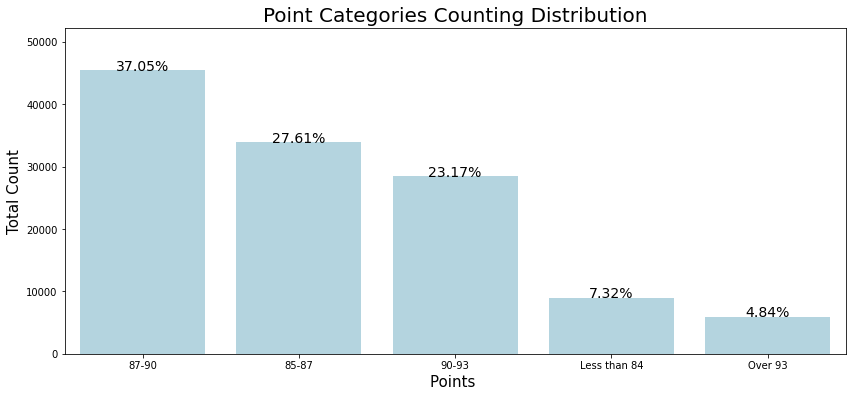

In [19]:
bars = ('87-90','85-87','90-93','< 84','> 93')


total = len(main_df_1)
plt.figure(figsize=(14,6))

g = sns.countplot(x='Points_Tier', color='lightblue',
                  data=main_df_1, order = main_df_1['Points_Tier'].value_counts().index)
g.set_title("Point Categories Counting Distribution", fontsize=20)
g.set_xlabel("Points ", fontsize=15)
g.set_ylabel("Total Count", fontsize=15)
g.set(xticklabels=['87-90','85-87','90-93','Less than 84','Over 93'])

sizes=[]

for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format((height/total)*100),
            ha="center", fontsize=14) 
    
g.set_ylim(0, max(sizes) * 1.15)

plt.show()

🍷  Most of the wine falls into our 87-90 points category (VERY GOOD)

🍷  A large percentage of the wines fall between the 85 to 93 point range

🍷  Less than 5 percent of the wines fall into the above 93 points category (SPECTACULAR)

🍷  A small percentage of wines were given a poor rating (lower than 84 points) (AVERAGE)

## Price EDA

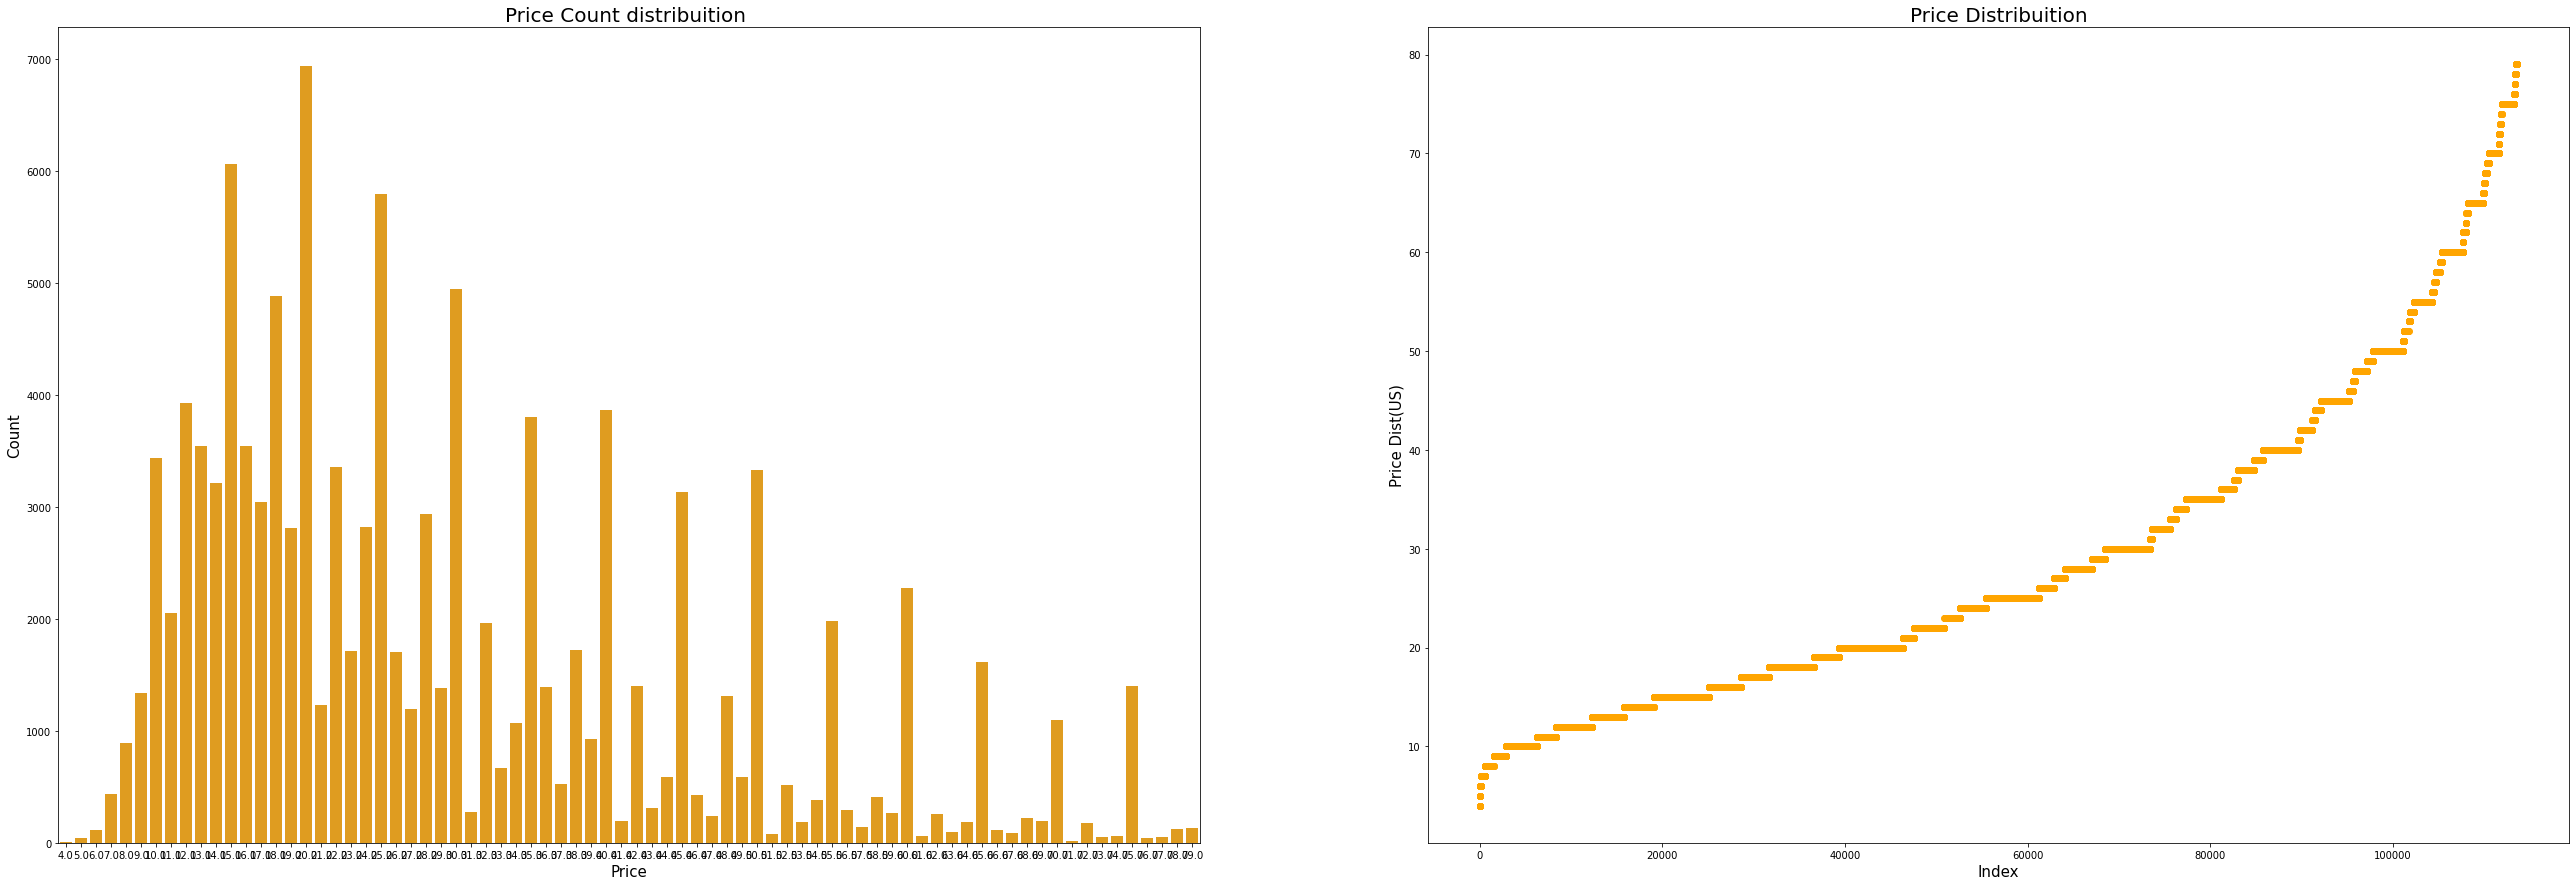

In [20]:
plt.figure(figsize=(45,15))

plt.subplot(1,2,1) 
g = sns.countplot(x='price', data=main_df_1, color='orange') 
g.set_title("Price Count distribuition ", fontsize=20) 
g.set_xlabel("Price", fontsize=15) 
g.set_ylabel("Count", fontsize=15) 

plt.subplot(1,2,2)  
plt.scatter(range(main_df_1.shape[0]), np.sort(main_df_1.price.values), color='orange') 
plt.xlabel('Index', fontsize=15)  
plt.ylabel('Price Dist(US)', fontsize=15) 
plt.title("Price Distribuition", fontsize=20) 

plt.show()

🍷 Way too much going on here so once again I will cluster price into different categories

In [21]:
main_df_1["price"].describe()

count    113670.000000
mean         29.114806
std          16.175015
min           4.000000
25%          16.000000
50%          25.000000
75%          39.000000
max          79.000000
Name: price, dtype: float64

In [22]:
conditions = [
    (main_df_1['price'] >= 65),
    (main_df_1['price'] >= 55) & (main_df_1['price'] < 65),
    (main_df_1['price'] >= 45) & (main_df_1['price'] < 55),
    (main_df_1['price'] >= 35) & (main_df_1['price'] < 45),
    (main_df_1['price'] >= 25) & (main_df_1['price'] < 35),
    (main_df_1['price'] >= 15) & (main_df_1['price'] < 25),
    (main_df_1['price'] < 15)]
    
# create a list of the values we want to assign for each condition
values = ['1st', '2nd', '3rd', "4th", "5th", "6th", "7th"]

# create a new column and use np.select to assign values to it using our lists as arguments
main_df_1['Price_Tier'] = np.select(conditions, values)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [23]:
main_df_1.dropna(subset = ["price"], inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [24]:
main_df_1["Price_Tier"].value_counts()

6th    36412
5th    21938
7th    19029
4th    14731
3rd    10197
2nd     5965
1st     5398
Name: Price_Tier, dtype: int64

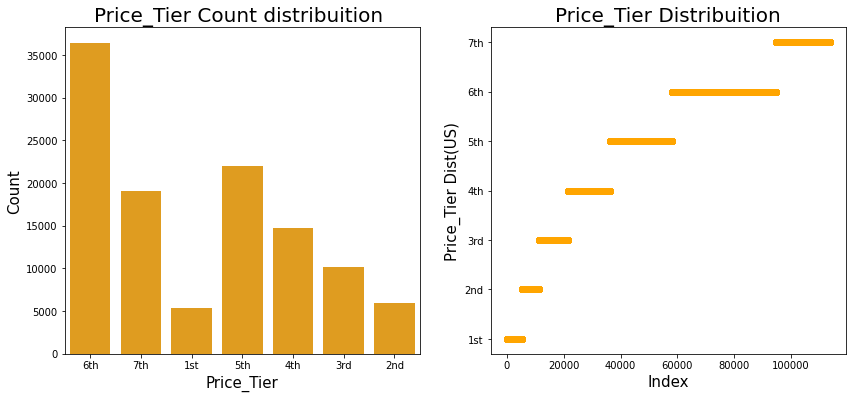

In [25]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1) 
g = sns.countplot(x='Price_Tier', data=main_df_1, color='orange') 
g.set_title("Price_Tier Count distribuition ", fontsize=20) 
g.set_xlabel("Price_Tier", fontsize=15) 
g.set_ylabel("Count", fontsize=15) 

plt.subplot(1,2,2)  
plt.scatter(range(main_df_1.shape[0]), np.sort(main_df_1.Price_Tier.values), color='orange') 
plt.xlabel('Index', fontsize=15)  
plt.ylabel('Price_Tier Dist(US)', fontsize=15) 
plt.title("Price_Tier Distribuition", fontsize=20) 

plt.show() #rendering the graphs

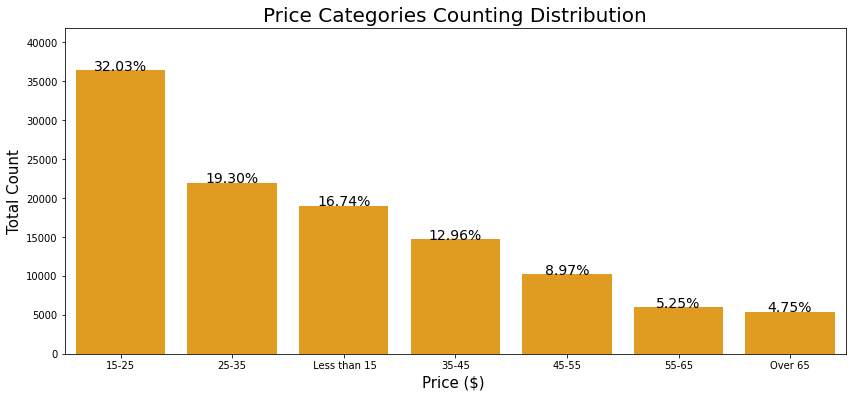

In [26]:
total = len(main_df_1)
plt.figure(figsize=(14,6))

g = sns.countplot(x='Price_Tier', color='orange',
                  data=main_df_1, order = main_df_1['Price_Tier'].value_counts().index)
g.set_title("Price Categories Counting Distribution", fontsize=20)
g.set_xlabel("Price ($) ", fontsize=15)
g.set_ylabel("Total Count", fontsize=15)
g.set(xticklabels=['15-25','25-35',' Less than 15','35-45','45-55', "55-65", "Over 65"])

sizes=[]

for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format((height/total)*100),
            ha="center", fontsize=14) 
    
g.set_ylim(0, max(sizes) * 1.15)

plt.show()

🍷 Finally a clearer picture of the breakdown in prices for our wine dataset

🍷 The most favourable price bracket seems to be between 15-25 dollars.

🍷 High-end bottles of wine (above $55 dollars) only make up about 10 percent of the dataset 


## Price vs Points 

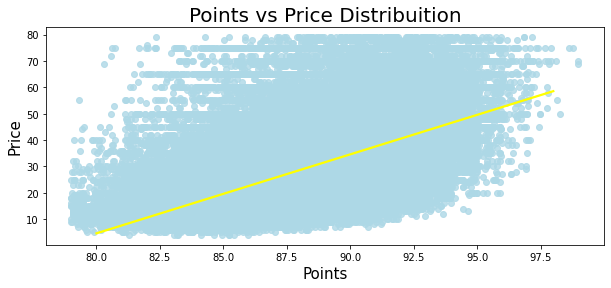

In [27]:
plt.figure(figsize=(10,4))

g = sns.regplot(x='points', y='price', 
                data=main_df_1, line_kws={'color':'yellow'},
                x_jitter=True, fit_reg=True, color='lightblue')
g.set_title("Points vs Price Distribuition", fontsize=20)
g.set_xlabel("Points", fontsize= 15)
g.set_ylabel("Price", fontsize= 15)

plt.show()

🍷  Again a little messy but clear to see that there is a positive linear relationship between price and points scored by the different wines.

🍷  As such it seems that points which are deemed to be of higher quality have a greater price tag attached to them which is not too surprising. 

## Country EDA 

In [28]:
main_df_1["country"].unique()

array(['Portugal', 'US', 'Spain', 'Italy', 'France', 'Germany',
       'Argentina', 'Chile', 'Australia', 'Austria', 'South Africa',
       'New Zealand', 'Israel', 'Hungary', 'Greece', 'Romania', 'Mexico',
       'Canada', 'Turkey', 'Czech Republic', 'Slovenia', 'Luxembourg',
       'Croatia', 'Georgia', 'Uruguay', 'England', 'Lebanon', 'Serbia',
       'Brazil', 'Moldova', 'Morocco', 'Peru', 'India', 'Bulgaria',
       'Cyprus', 'Armenia', 'Switzerland', 'Bosnia and Herzegovina',
       'Ukraine', 'Slovakia', 'Macedonia', 'China'], dtype=object)

In [29]:
plot_data = main_df_1.groupby('country').size().sort_values(ascending = True)
plot_data

country
Slovakia                      1
China                         1
Armenia                       2
Bosnia and Herzegovina        2
Switzerland                   4
Luxembourg                    6
India                         9
Cyprus                       11
Macedonia                    12
Serbia                       12
Czech Republic               12
Ukraine                      14
Peru                         16
Morocco                      28
Lebanon                      35
Brazil                       47
Moldova                      59
England                      63
Mexico                       68
Croatia                      71
Slovenia                     79
Georgia                      84
Turkey                       89
Uruguay                     107
Romania                     118
Hungary                     137
Bulgaria                    140
Canada                      239
Greece                      461
Israel                      476
South Africa               1260


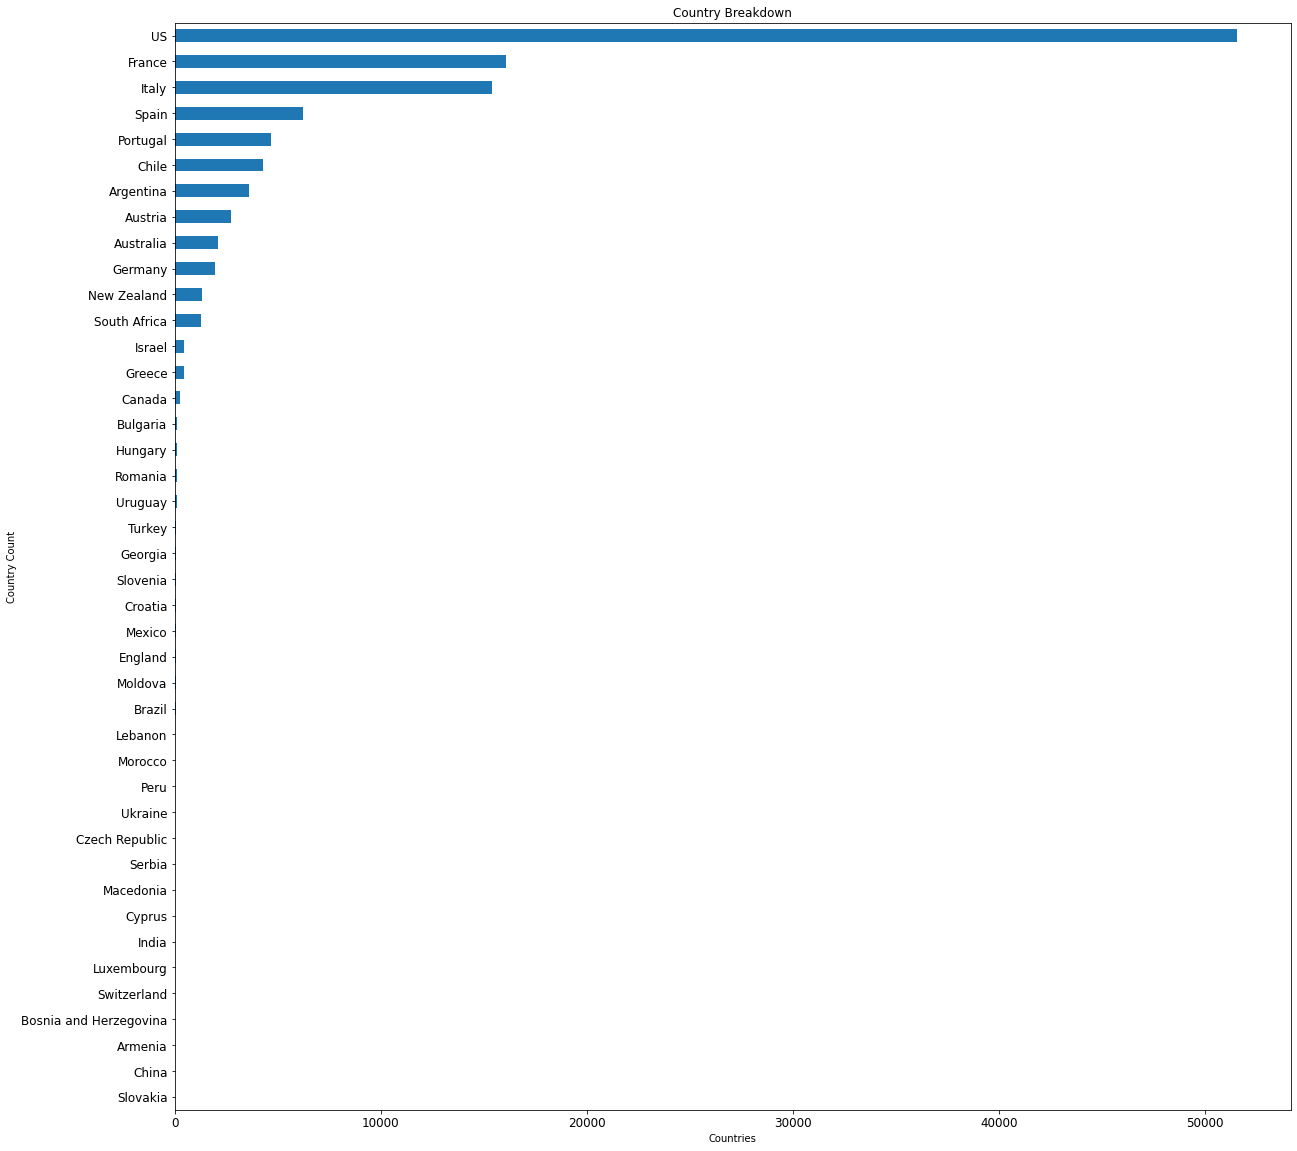

In [30]:
plt.figure(figsize = (20,20))
plot_data.plot(kind="barh",  fontsize=12)
plt.title("Country Breakdown")
plt.xlabel("Countries")
plt.ylabel("Country Count")
plt.show()

🍷  Its pretty clear that most of the wines in this dataset come from 15 countries. I will take a closer look at this top 12.

In [31]:
plot_data = main_df_1.groupby('country').size().sort_values(ascending = True).tail(12)
plot_data

country
South Africa     1260
New Zealand      1350
Germany          1947
Australia        2108
Austria          2728
Argentina        3600
Chile            4300
Portugal         4696
Spain            6233
Italy           15386
France          16095
US              51564
dtype: int64

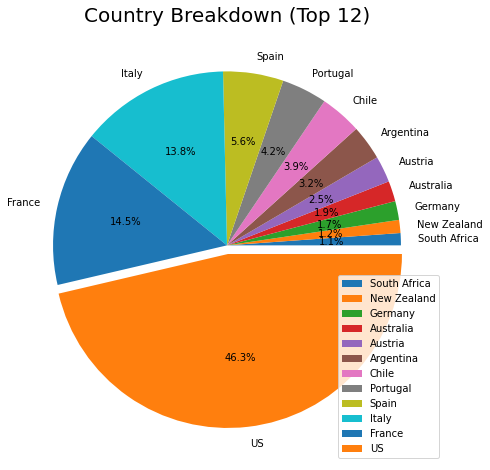

In [32]:
mylabels = ["South Africa", "New Zealand", 
            "Germany","Australia", "Austria","Argentina","Chile",
            "Portugal","Spain","Italy","France","US"]
myexplode = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.05 ]
plt.figure(figsize = (8,8))
plt.title("Country Breakdown (Top 12)", fontsize=20)
plt.pie(plot_data, autopct='%1.1f%%', labels=mylabels, explode = myexplode)
plt.legend()
plt.show()

🍷  Pretty clear that the 3 power house countries in this dataset are: The U.S, France and Italy



🍷  Lets compare the top 12 with prices and points

In [33]:
country = main_df_1[main_df_1["country"].isin(mylabels)]
country

,country,description,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,Points_Tier,Price_Tier
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,3rd,6th
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,3rd,7th
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,3rd,7th
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,3rd,1st
5,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,3rd,6th
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,90,28.0,Mosel,NaN,NaN,Anna Lee C. Iijima,NaN,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef),2nd,5th
129967,US,Citation is given as much as a decade of bottl...,90,75.0,Oregon,Oregon,Oregon Other,Paul Gregutt,@paulgwine,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation,2nd,1st
129968,France,Well-drained gravel soil gives this wine its c...,90,30.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2nd,5th
129969,France,"A dry style of Pinot Gris, this is crisp with ...",90,32.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss,2nd,5th


In [34]:
size = country.groupby("country").agg({"points": "mean","price": "mean", "country": "count"})
size


,points,price,country
country,,,
Argentina,86.490556,20.615000,3600
Australia,88.250949,26.090607,2108
Austria,90.103006,28.667155,2728
Chile,86.367442,18.195349,4300
France,88.304753,27.731594,16095
Germany,89.561376,29.295840,1947
Italy,88.302678,31.367672,15386
New Zealand,88.245926,25.424444,1350
Portugal,88.120954,21.268952,4696


🍷  Above is a dataframe that consists of the Top 12 producing countries with their average points scored, average prices per bottle and total count (under country column)

In [35]:
import plotly.express as px


fig = px.scatter(size, x="points", y="price", log_x=True,
                 hover_name=size.index, hover_data=["country"], title = "Average Points and Prices for Top 12 Countries", color = size.index, size = "country", size_max = 50)

fig.update_layout(
    xaxis={
        'title':'Average Points'},
    yaxis={'title':'Average Price'})


fig.show()

There are many interesting observations that can be made from the above graphic!

🍷  If you are after excellent wines at a resonable price you should go lloking for **Austrian** wine

🍷  Of the mid performing wines **Portugese** wine could be a good option as it is priced on average below 22 dollars but averages a rating of over 88 points out of 100

🍷  If you arent too concerned about overall ratings points and are just looking for a bargain **Chilean **wine is great bet!

🍷  It must be said that while wine for the **U.S** is the most expensive on average, it does perform really well on average considing that it holds by far and away the largest market share

🍷  **Italian** Wine and **French** Wine recieve perform almost identically while occupying almost the same market share. However, **French** wine is on average more than 3 dollars cheaper

## Taster EDA

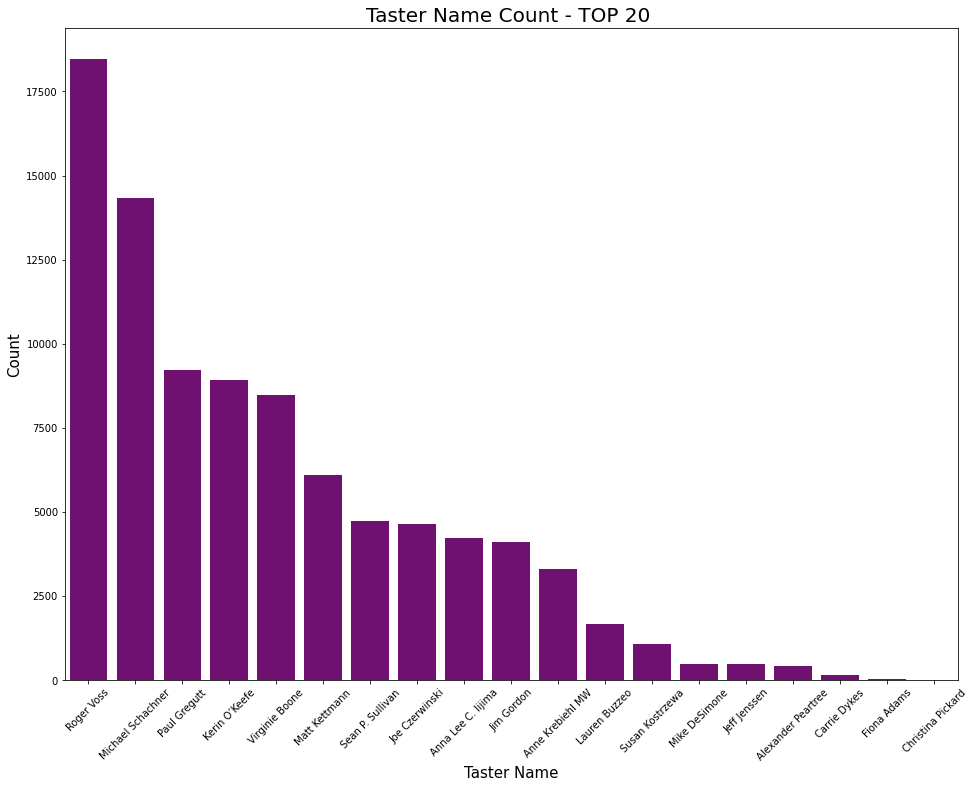

In [36]:
plt.figure(figsize=(16,12))

g = sns.countplot(x="taster_name",data=main_df_1, color='purple', order=main_df_1['taster_name'].value_counts().index)
g.set_title("Taster Name Count - TOP 20 ", fontsize=20)
g.set_xlabel("Taster Name", fontsize=15)
g.set_ylabel("Count", fontsize=15)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
plt.show()



🍷  Roger Voss and Michael Schacher look to be the two most active tasters

🍷  Most of the tasting notes seem to come from the Top 11 tasters. As such I will take a deeer dive into these **"Top 11 Tasters"**

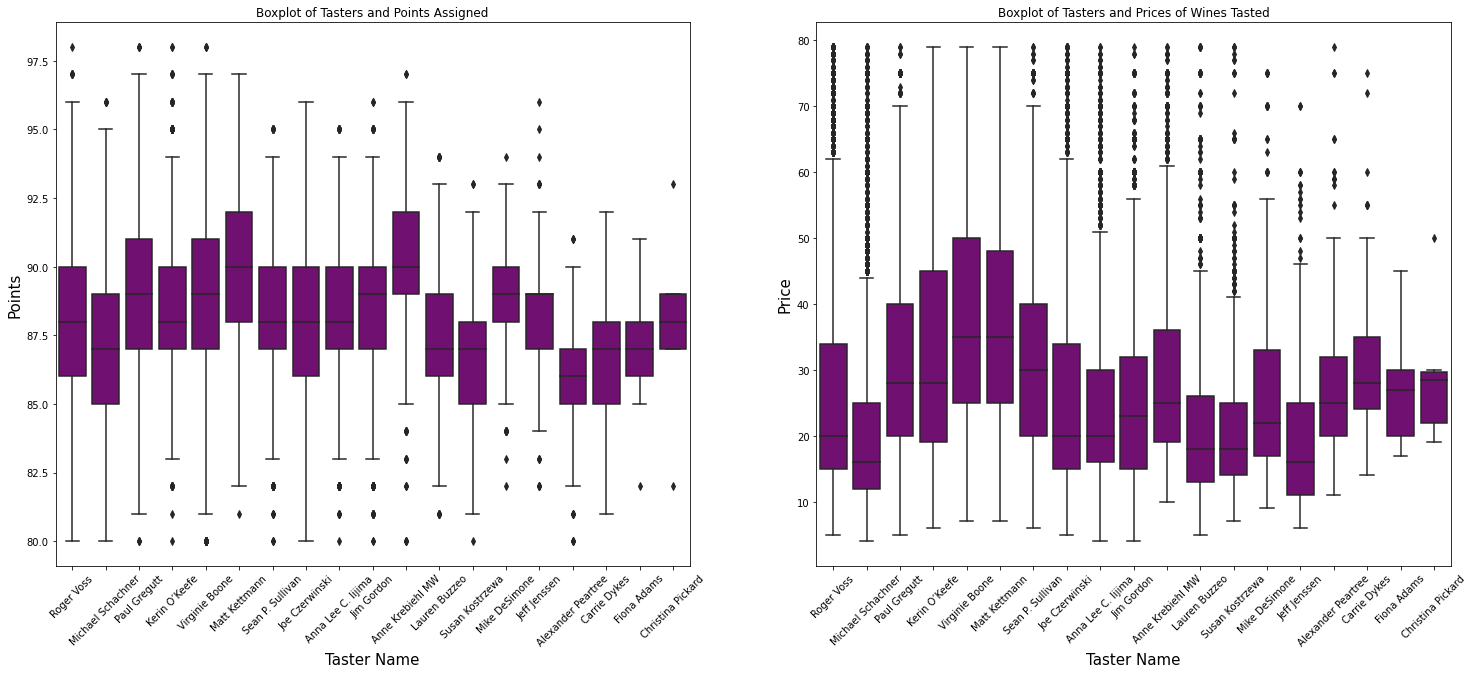

In [37]:
plt.figure(figsize = (25, 10))

plt.subplot(1, 2, 1)
points = sns.boxplot(y='points', x='taster_name',
                  data=main_df_1, color='purple', order=main_df_1['taster_name'].value_counts().index )
plt.title("Boxplot of Tasters and Points Assigned")
points.set_xlabel("Taster Name", fontsize=15)
points.set_ylabel("Points", fontsize=15)
points.set_xticklabels(points.get_xticklabels(),rotation=45)

plt.subplot(1, 2, 2)
price = sns.boxplot(y='price', x='taster_name',
                  data=main_df_1, color='purple', order=main_df_1['taster_name'].value_counts().index)
plt.title("Boxplot of Tasters and Prices of Wines Tasted")
price.set_xlabel("Taster Name", fontsize=15)
price.set_ylabel("Price", fontsize=15)
price.set_xticklabels(price.get_xticklabels(),rotation=45)

plt.show()


🍷  Some of the observations we can draw from these boxplots include:

**TASTERS VS POINTS ASSIGNED**

🍷 🍷  Joe Czerwinski seems to rate his wines in the widest range with an upper whhisker of close to 98 points but a lower whisker of close to the minimum of 79 points. 

🍷 🍷  Matt Kettmann looks to give out the highest rating on average. 

🍷 🍷  Alexander Peartree seems to give out the lowest ratings on average. 

🍷 🍷  The top 2 tasters with the most ratings (Roger Voss and Michael Schacher) seem to average their ratings around 87.5 points out of 100

**TASTERS VS PRICE of WINES TASTED**

🍷 🍷 Kerin O'Keefe, Virginie Boone and Matt Kettman seem to be the three tasters in the top 11 who have tasted the largest range of priced wines (Below 10 dollars to almost 80 dollars). It looks as if Boone and Kettman focus on average on the most expensive wine of the top 11 tasters. 

🍷 🍷 Of the top two tasters (Roger Voss and Michael Schacher), Schacher seems to focus on rating cheaper wines. 





## Wine Varietals EDA

In [38]:
main_df_1["variety"].value_counts()

Pinot Noir                  11831
Chardonnay                  10590
Red Blend                    7931
Cabernet Sauvignon           7885
Riesling                     4778
                            ...  
Silvaner-Traminer               1
Roussanne-Grenache Blanc        1
País                            1
Thrapsathiri                    1
Tokay Pinot Gris                1
Name: variety, Length: 686, dtype: int64

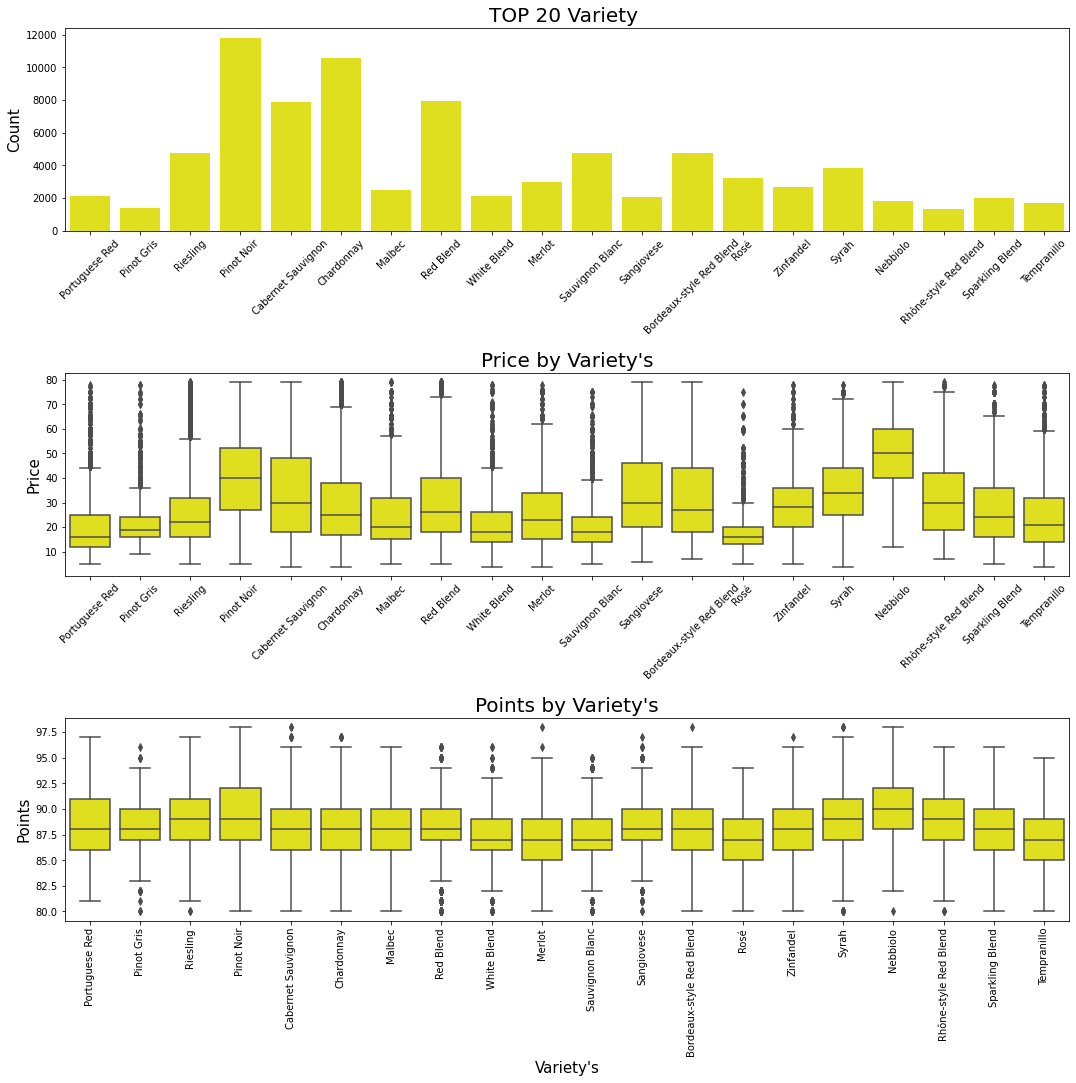

In [39]:
plt.figure(figsize=(18,16))

variety = main_df_1.variety.value_counts()[:20]

plt.subplot(3,1,1)
g = sns.countplot(x='variety', 
                  data=main_df_1.loc[(main_df_1.variety.isin(variety.index.values))], 
                  color='yellow')
g.set_title("TOP 20 Variety ", fontsize=20)
g.set_xlabel(" ", fontsize=15)
g.set_ylabel("Count", fontsize=15)
g.set_xticklabels(g.get_xticklabels(),rotation=45)

plt.subplot(3,1,2)
g1 = sns.boxplot(y='price', x='variety',
                  data=main_df_1.loc[(main_df_1.variety.isin(variety.index.values))], 
                 color='yellow')
g1.set_title("Price by Variety's", fontsize=20)
g1.set_xlabel("", fontsize=15)
g1.set_ylabel("Price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)

plt.subplot(3,1,3)
g2 = sns.boxplot(y='points', x='variety',
                  data=main_df_1.loc[(main_df_1.variety.isin(variety.index.values))], 
                 color='yellow')
g2.set_title("Points by Variety's", fontsize=20)
g2.set_xlabel("Variety's", fontsize=15)
g2.set_ylabel("Points", fontsize=15)
g2.set_xticklabels(g2.get_xticklabels(),rotation=90)

plt.subplots_adjust(hspace = 0.7,top = 0.9)

plt.show()

🍷 🍷 Above we can see the top 20 most popular varietals of wine included in this dataset. 

🍷 🍷 On average its seems Nebbiolo ranks the highest in terms of price and ratings points. 

🍷 🍷 Of the top 4 most popular wine varietals (Pinot Noir, Cabernet Sauvignon, Chardonnay and Red Blend), Pinot Noir looks to be the most expensive on average with Chardonnay and Cab Sav performing very similarly in terms of average points scored. 

🍷 🍷 Rosé looks to be the cheapest varietal on average.

## Wine Descriptions EDA

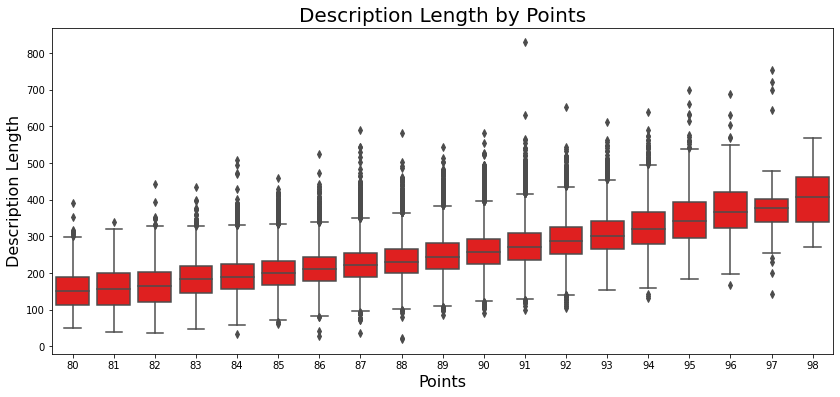

In [40]:
main_df_1 = main_df_1.assign(desc_length = main_df_1['description'].apply(len))

plt.figure(figsize=(14,6))
g = sns.boxplot(x='points', y='desc_length', data=main_df_1,
                color='red')
g.set_title('Description Length by Points', fontsize=20)
g.set_ylabel('Description Length', fontsize = 16) 
g.set_xlabel('Points', fontsize = 16) 
plt.show()


🍷  It appears that the length of description is positively correlated to points scored.

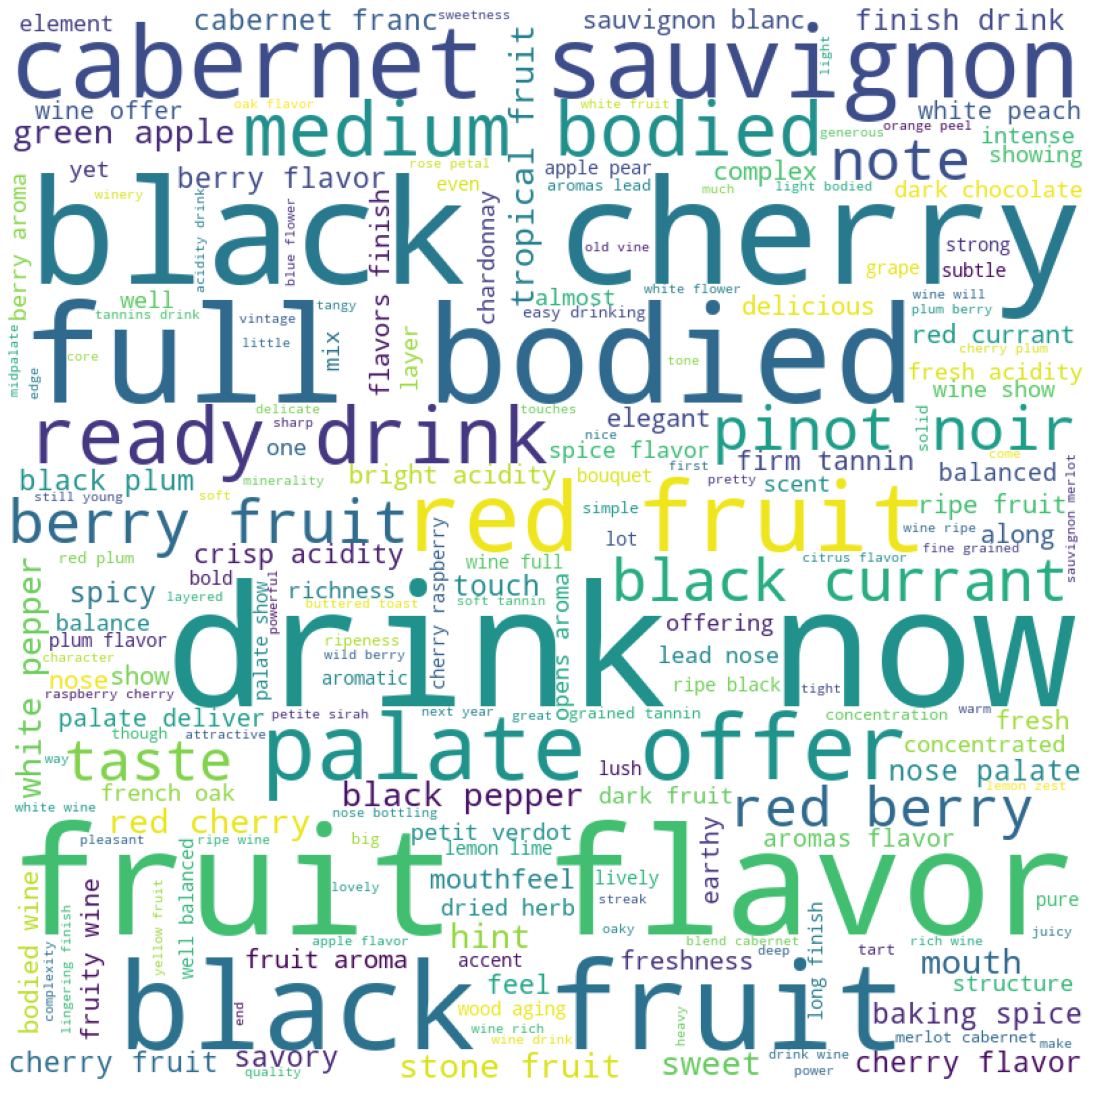

In [41]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
 
comment_words = ''
stopwords = set(STOPWORDS)
 
for val in main_df_1.description:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (15, 15), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

🍷 🍷 Above is a word cloud of the descriptions of the wines given by the tasters. 

🍷 🍷 The larger the word in the cloud the more frequently it has been used in the wines descriptions.

🍷 🍷 The standouts include: Fruit flavor, Black cherry, Full bodied, Drink now and Red fruit

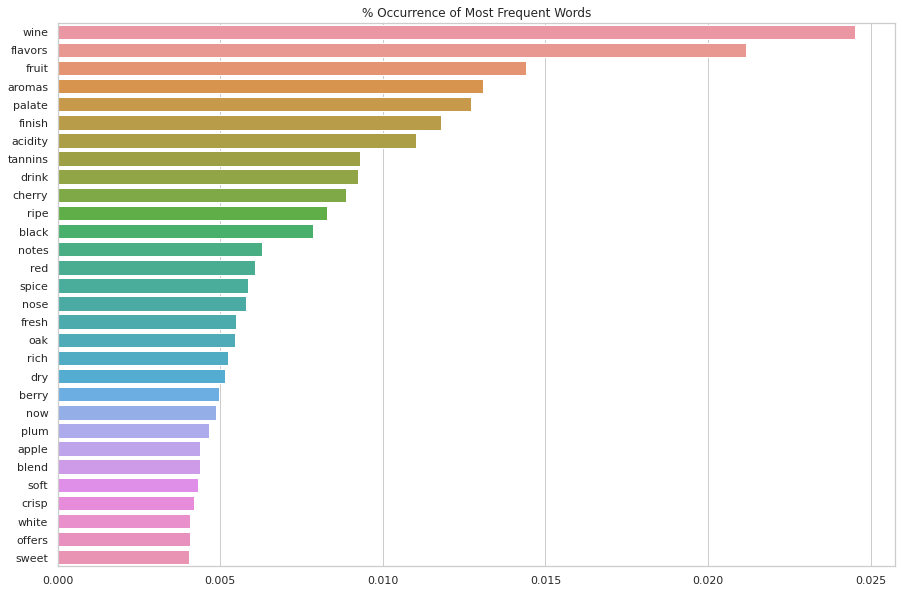

In [42]:
# set seaborn style 
sns.set(style="whitegrid")

stopwords = set(STOPWORDS)
# Detokenizer combines tokenized elements
detokenizer = TreebankWordDetokenizer()

def clean_description(desc):
    desc = word_tokenize(desc.lower())
    desc = [token for token in desc if token not in stopwords and token.isalpha()]
    return detokenizer.detokenize(desc)

main_df_1["cleaned_description"] = main_df_1["description"].apply(clean_description)

word_occurrence = main_df_1["cleaned_description"].str.split(expand=True).stack().value_counts()

total_words = sum(word_occurrence)

# plot most common words 

top_words = word_occurrence[:30]/total_words

plt.figure(figsize = (15,10))
ax = sns.barplot(x = top_words.values, y = top_words.index)


ax.set_title("% Occurrence of Most Frequent Words")

plt.show()

🍷 🍷 The descriptions have been tokenized and cleaned as seen above. 

🍷 🍷 Next the now cleaned descriptions have been used to find the individual words which appear the most in the descriptions of the wines. 

🍷 🍷 By war and away the two most frequent words are wine and flavours.  

In [43]:
main_df_1

,country,description,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,Points_Tier,Price_Tier,desc_length,cleaned_description
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,3rd,6th,227,ripe fruity wine smooth still structured firm ...
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,3rd,7th,186,tart snappy flavors lime flesh rind dominate g...
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,3rd,7th,199,pineapple rind lemon pith orange blossom start...
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,3rd,1st,249,much regular bottling comes across rather roug...
5,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,3rd,6th,261,blackberry raspberry aromas show typical navar...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,90,28.0,Mosel,NaN,NaN,Anna Lee C. Iijima,NaN,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef),2nd,5th,227,notes honeysuckle cantaloupe sweeten delicious...
129967,US,Citation is given as much as a decade of bottl...,90,75.0,Oregon,Oregon,Oregon Other,Paul Gregutt,@paulgwine,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation,2nd,1st,233,citation given much decade bottle age prior re...
129968,France,Well-drained gravel soil gives this wine its c...,90,30.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2nd,5th,225,gravel soil gives wine crisp dry character rip...
129969,France,"A dry style of Pinot Gris, this is crisp with ...",90,32.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss,2nd,5th,216,dry style pinot gris crisp acidity weight soli...


🍷 🍷 The final table above will be used for to run our model. 

🍷 🍷 Around 114 000 entries remain following cleaning and the use of cleaned descriptions. 

# Model 1: Description Vectorization

🍷 Count Vectorization is a way we can represent text data numerically. This technique is similar to one-hot encoding (or count vectorization)

🍷 Create vectors that have a dimensionality equal to the size of our vocabulary (in this case my cleaned wine descriptions) 


🍷 If the wine descriptions features a certain word, a one will be put in that dimension. Every time we encounter that word again, the count will be increased, leaving 0s everywhere a word was not found.

🍷 Counts the number of times a token shows up and uses this value as its weight.





In [44]:
main_df_1

,country,description,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,Points_Tier,Price_Tier,desc_length,cleaned_description
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,3rd,6th,227,ripe fruity wine smooth still structured firm ...
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,3rd,7th,186,tart snappy flavors lime flesh rind dominate g...
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,3rd,7th,199,pineapple rind lemon pith orange blossom start...
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,3rd,1st,249,much regular bottling comes across rather roug...
5,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,3rd,6th,261,blackberry raspberry aromas show typical navar...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,90,28.0,Mosel,NaN,NaN,Anna Lee C. Iijima,NaN,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef),2nd,5th,227,notes honeysuckle cantaloupe sweeten delicious...
129967,US,Citation is given as much as a decade of bottl...,90,75.0,Oregon,Oregon,Oregon Other,Paul Gregutt,@paulgwine,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation,2nd,1st,233,citation given much decade bottle age prior re...
129968,France,Well-drained gravel soil gives this wine its c...,90,30.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2nd,5th,225,gravel soil gives wine crisp dry character rip...
129969,France,"A dry style of Pinot Gris, this is crisp with ...",90,32.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss,2nd,5th,216,dry style pinot gris crisp acidity weight soli...


## Count Vectorizer on Uncleaned Description

In [45]:
from sklearn.feature_extraction.text import CountVectorizer
X = main_df_1['description']
y = main_df_1['Points_Tier']

vectorizer = CountVectorizer()
vectorizer.fit(X)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [46]:
X = vectorizer.transform(X)
print('Shape of Sparse Matrix: ', X.shape)
print('Amount of Non-Zero occurrences: ', X.nnz)
# Percentage of non-zero values
density = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print('Density: {}'.format((density)))

Shape of Sparse Matrix:  (113670, 29108)
Amount of Non-Zero occurrences:  3889641
Density: 0.11755775752793005


In [47]:
# Training the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

# Testing the model
predictions = rfc.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1st       1.00      0.07      0.13      1579
         2nd       0.62      0.55      0.58      6248
         3rd       0.54      0.81      0.65      8397
         4th       0.63      0.53      0.57      5325
         5th       0.87      0.17      0.29      1185

    accuracy                           0.58     22734
   macro avg       0.73      0.42      0.44     22734
weighted avg       0.63      0.58      0.56     22734



🍷 The results of a Random Forest Classifier using Count Vectorization on the Uncleaned Wine Descriptions can be seen above. 

🍷 The results are a little underwhelming. 

🍷 The dataset is a little scewed as most of the wines fall into categories 2-4 as explained above. 

🍷 As such the model seems to be having trouble correctly identifying wines which fall into category 1 (SPECTACULAR) and category 4 (AVERAGE). 

🍷 For the wines which fall into categories 2-4 the F1 scores are 0.57, 0.65 and 0.57 respectively. F1 scores embed precision and recall into their computation and shows the models ability to correctly predict low false positives and low false negatives. 

🍷 Not great but its a starting point!

## Count Vectorizer on Cleaned Description

In [48]:
from sklearn.feature_extraction.text import CountVectorizer
X = main_df_1['cleaned_description']
y = main_df_1['Points_Tier']

vectorizer = CountVectorizer()
vectorizer.fit(X)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [49]:
X = vectorizer.transform(X)
print('Shape of Sparse Matrix: ', X.shape)
print('Amount of Non-Zero occurrences: ', X.nnz)
# Percentage of non-zero values
density = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print('Density: {}'.format((density)))

Shape of Sparse Matrix:  (113670, 27736)
Amount of Non-Zero occurrences:  2630665
Density: 0.0834403002289632


In [50]:
# Training the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
rfc = RandomForestClassifier()
model = rfc.fit(X_train, y_train)
model

# Testing the model
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1st       1.00      0.07      0.14       786
         2nd       0.63      0.53      0.58      3133
         3rd       0.54      0.81      0.65      4138
         4th       0.64      0.55      0.59      2716
         5th       0.79      0.27      0.41       594

    accuracy                           0.59     11367
   macro avg       0.72      0.45      0.47     11367
weighted avg       0.64      0.59      0.57     11367



🍷 The results of a Random Forest Classifier using Count Vectorization on the Cleaned Wine Descriptions can be seen above. 

🍷  Slightly better but no major improvement. 

# Model 2: Sentiment Analysis

🍷 Sentiment analysis is the process of detecting positive, neutral or negative sentiment in text. 

In [51]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

SIA = SentimentIntensityAnalyzer()

# Applying Model, Variable Creation
sentiment = main_df_1.copy()
sentiment['polarity_score']=sentiment.description.apply(lambda x:SIA.polarity_scores(x)['compound'])
sentiment['neutral_score']=sentiment.description.apply(lambda x:SIA.polarity_scores(x)['neu'])
sentiment['negative_score']=sentiment.description.apply(lambda x:SIA.polarity_scores(x)['neg'])
sentiment['positive_score']=sentiment.description.apply(lambda x:SIA.polarity_scores(x)['pos'])

sentiment['sentiment']= np.nan
sentiment.loc[sentiment.polarity_score>0,'sentiment']='POSITIVE'
sentiment.loc[sentiment.polarity_score==0,'sentiment']='NEUTRAL'
sentiment.loc[sentiment.polarity_score<0,'sentiment']='NEGATIVE'

In [52]:
sentiment

,country,description,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,Points_Tier,Price_Tier,desc_length,cleaned_description,polarity_score,neutral_score,negative_score,positive_score,sentiment
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,3rd,6th,227,ripe fruity wine smooth still structured firm ...,0.6486,0.868,0.000,0.132,POSITIVE
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,3rd,7th,186,tart snappy flavors lime flesh rind dominate g...,-0.1280,0.947,0.053,0.000,NEGATIVE
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,3rd,7th,199,pineapple rind lemon pith orange blossom start...,0.3400,0.926,0.000,0.074,POSITIVE
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,3rd,1st,249,much regular bottling comes across rather roug...,0.8176,0.805,0.000,0.195,POSITIVE
5,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,3rd,6th,261,blackberry raspberry aromas show typical navar...,0.1655,0.960,0.000,0.040,POSITIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,90,28.0,Mosel,NaN,NaN,Anna Lee C. Iijima,NaN,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef),2nd,5th,227,notes honeysuckle cantaloupe sweeten delicious...,0.7331,0.834,0.000,0.166,POSITIVE
129967,US,Citation is given as much as a decade of bottl...,90,75.0,Oregon,Oregon,Oregon Other,Paul Gregutt,@paulgwine,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation,2nd,1st,233,citation given much decade bottle age prior re...,0.5267,0.914,0.000,0.086,POSITIVE
129968,France,Well-drained gravel soil gives this wine its c...,90,30.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser,2nd,5th,225,gravel soil gives wine crisp dry character rip...,0.1548,0.865,0.072,0.063,POSITIVE
129969,France,"A dry style of Pinot Gris, this is crisp with ...",90,32.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss,2nd,5th,216,dry style pinot gris crisp acidity weight soli...,0.5267,0.891,0.000,0.109,POSITIVE


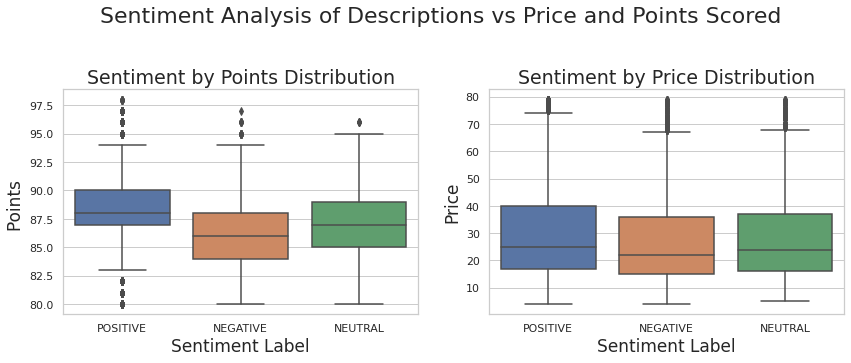

In [53]:
plt.figure(figsize=(14,5))

plt.suptitle("Sentiment Analysis of Descriptions vs Price and Points Scored", size=22)

plt.subplot(121)
ax = sns.boxplot(x='sentiment', y='points', data=sentiment)
ax.set_title("Sentiment by Points Distribution", fontsize=19)
ax.set_ylabel("Points ", fontsize=17)
ax.set_xlabel("Sentiment Label", fontsize=17)

plt.subplot(122)
ax1= sns.boxplot(x='sentiment', y='price', data=sentiment)
ax1.set_title("Sentiment by Price Distribution", fontsize=19)
ax1.set_ylabel("Price", fontsize=17)
ax1.set_xlabel("Sentiment Label", fontsize=17)

plt.subplots_adjust(top = 0.75, wspace=.2)
plt.show()

🍷 Interesting findings! It looks as if the wines with positive reviews recieve on average higher points. Similarly Neturally reviewed wines seem to perform better on average than negatively reviewed wines. 

🍷 When it comes to price there does not seem to be any major difference between these wines based on sentiment. Does the review actually affect the price of the wine? Looks like no. 

# Save Model Results

In [ ]:
import joblib
joblib.dump(model, "./random_forest.joblib")

['./random_forest.joblib']

In [ ]:
path = "/content/drive/MyDrive/Model Outputs - Colab"
loaded_rfc = joblib.load("./random_forest.joblib")

In [ ]:
predictions = loaded_rfc.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1st       1.00      0.08      0.14       786
         2nd       0.63      0.53      0.57      3133
         3rd       0.54      0.80      0.65      4138
         4th       0.63      0.54      0.59      2716
         5th       0.80      0.28      0.41       594

    accuracy                           0.59     11367
   macro avg       0.72      0.45      0.47     11367
weighted avg       0.63      0.59      0.56     11367

